In [60]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from scipy.stats import norm

In [61]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None
df = pd.read_csv("src/listings_summary.csv")

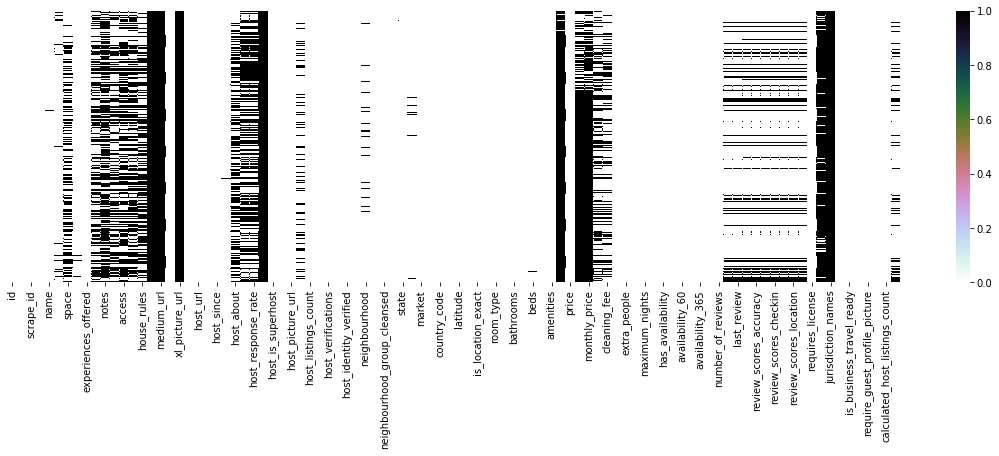

In [62]:
#source : https://www.kaggle.com/mhmdpkts/predict-price-ann-data-cleaning-future-engineering
fig, ax = plt.subplots(figsize = (20, 5))
sns.heatmap(df.isna(), cmap = "cubehelix_r", yticklabels='')
plt.show()

In [63]:
#Sort out the Price-Section
df.price = df.price.str.replace('$', '').str.replace(',', '').astype(float)
df.cleaning_fee = df.cleaning_fee.str.replace('$', '').str.replace(',', '').astype(float)
df.security_deposit = df.security_deposit.str.replace('$', '').str.replace(',', '').astype(float)
df.extra_people = df.extra_people.str.replace('$', '').str.replace(',', '').astype(float)

df['cleaning_fee'].fillna(0, inplace=True)
df['security_deposit'].fillna(0, inplace=True)
#  + df['cleaning_fee'] + df['security_deposit']
df['total_price'] = df['price']
df.drop(['price'], inplace=True, axis = 1)

In [64]:
def nan_checker(df):
    df_nan = pd.DataFrame([[var, df[var].isna().sum() / df.shape[0], df[var].dtype]
                           for var in df.columns if df[var].isna().sum() > 0],
                          columns=['var', 'proportion', 'dtype'])
    return df_nan

In [65]:
#removing 100% of the NULL values and identity values
col_list_to_drop = [] 
columns = df.columns
df_nan = nan_checker(df)
length = len(df)
for col in df.columns:  
    if (df[col].dtype != 'float64'and df[col].nunique(dropna=True) == df[col].notnull().sum()):
        col_list_to_drop.append(col)
df.drop(col_list_to_drop, inplace=True, axis = 1)

In [66]:
for row in df_nan.iterrows():
    column_name = row[1]['var']
    rate = round(row[1]['proportion'], 3)
    if rate > 0.5:
        df.drop(column_name, inplace=True, axis = 1)

In [67]:
#df.describe(include="all")

We will not need columns containing the following types of data-for our analysis


columns with only true/false values
columns that have text (not within the scope of our analysis)
columns containing personnel information, except for the ones that guranntee some kind of assurance(licence, or profile pictures)

Make everything as relevant, unless it is really irrelevant to your prediction.

In [68]:
review_host_text_columns =["scrape_id",
                           "picture_url",
                           "last_scraped",
                           "name",
                           "summary", 
                           "space",
                           "description",
                           "experiences_offered", 
                           "neighborhood_overview",
                           "transit",
                           "house_rules", 
                           "host_id",
                           "host_url",
                           "host_location",
                           "host_neighbourhood",
                           "host_name",
                           "host_since", 
                           "host_thumbnail_url",
                           "host_picture_url",
                           "host_listings_count",
                           "host_total_listings_count", 
                           "host_verifications",
                           "calendar_updated",
                           "has_availability",
                           "availability_30",
                           "availability_60",
                           "availability_90",
                           "calendar_last_scraped",
                           "number_of_reviews",
                           "first_review",
                           "last_review",
                           "review_scores_rating",
                           "review_scores_accuracy",
                           "review_scores_cleanliness",
                           "review_scores_checkin",
                           "review_scores_communication",
                           "review_scores_location",
                           "review_scores_value",
                           "calculated_host_listings_count", 
                           "reviews_per_month"]

df_dropped = df.drop(review_host_text_columns, inplace=False, axis = 1).copy(deep=True)
#df_dropped.describe(include="all")

<h3>Work on the Missing Data</h3>

 1) Strategy 1: Drop all missing rows and check the outcome
 
 2) Strategy 2: Impute the missing values with mean or most repetative element


In [69]:
#Strategy 1 
df_dropped_rows = df_dropped.dropna()
percentange_of_rows_dropped = (len(df_dropped) - len(df_dropped_rows))/len(df_dropped)
print("Percentage of Rows Dropped  {}".format(percentange_of_rows_dropped * 100))

Percentage of Rows Dropped  8.832919474991131


In [70]:
#strategy 2 Imputing all the values
from sklearn.impute import SimpleImputer
#filling all the missing values with mean
numerical_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
category__imputer = SimpleImputer(missing_values=np.nan,strategy="most_frequent")


In [71]:
df_dropped_imputed = df_dropped_rows.copy(deep=True)
df_nan = nan_checker(df_dropped_imputed)
for row in df_nan.iterrows():
    column_name = row[1]['var']
    if df_dropped_imputed[column_name].dtype == 'float64':
        df_dropped_imputed[column_name] = numerical_imputer.fit_transform(df_dropped_imputed[[column_name]])
    else:
        df_dropped_imputed[column_name] = category__imputer.fit_transform(df_dropped_imputed[[column_name]])

<h1> Null Data Removed for all columns </h1>

In [72]:
#decide between strategy 1 or 2
df_na_filtered = df_dropped_imputed.copy(deep=True)

Dropping all information related to location, except for neighbour_group_cleansed: This column indicates which part of berlin the listings are located in. Secondly, the lattitude and logitude would be converted to distance from centre.

Location Columns having highly skewed values will be removed, todo: need a visual aid of all the columns and count of each value (except for latitude and longitude)

In [73]:
df_na_filtered.drop(location_columns, axis=1, inplace=True)

In [74]:
#Using the Lattitue and Logitude to convert to a distance from the city center,

#source : https://www.kaggle.com/mhmdpkts/predict-price-ann-data-cleaning-future-engineering
#create distance feature from latitude and longtitude 
from geopy.distance import great_circle
def distance_from_berlin(lat, lon):
    berlin_centre = (52.5027778, 13.404166666666667)
    record = (lat, lon)
    #returns surface distance in kilometers
    return great_circle(berlin_centre, record).km

#add distanse dataset
df_na_filtered['distance'] = df_na_filtered.apply(lambda x: distance_from_berlin(x.latitude, x.longitude), axis=1)
df_na_filtered.drop(['latitude', 'longitude'], axis=1, inplace=True)
df_na_filtered.head()

,host_is_superhost,host_has_profile_pic,host_identity_verified,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_365,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,total_price,distance
0,t,t,t,Guesthouse,Entire home/apt,3,1.0,1.0,2.0,Real Bed,"{TV,""Cable TV"",Wifi,Kitchen,Gym,Heating,""Famil...",200.0,30.0,1,28.0,4,1125,141,t,f,f,strict_14_with_grace_period,f,f,60.0,3.533182
2,f,t,t,Apartment,Entire home/apt,4,1.0,1.0,2.0,Real Bed,"{Internet,Wifi,Kitchen,""Buzzer/wireless interc...",200.0,50.0,2,20.0,62,1125,220,t,t,f,strict_14_with_grace_period,f,f,90.0,3.695677
3,f,t,t,Apartment,Private room,2,1.0,1.0,1.0,Pull-out Sofa,"{Internet,Wifi,""Pets allowed"",""Pets live on th...",250.0,30.0,1,18.0,5,360,297,t,f,f,strict_14_with_grace_period,f,f,26.0,3.755285
4,t,t,t,Apartment,Private room,2,1.0,1.0,2.0,Real Bed,"{Wifi,Heating,""Family/kid friendly"",Essentials...",0.0,0.0,1,24.0,2,10,26,t,f,f,moderate,f,f,42.0,4.550423
5,f,t,t,Apartment,Entire home/apt,7,2.5,4.0,7.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Paid par...",400.0,80.0,5,10.0,6,14,137,t,f,f,strict_14_with_grace_period,f,f,180.0,3.458693


In [75]:
#Converting the boolean to 0 or 1 value,
boolean_mapping =  {
    'True':1, 'False':0,
    't':1, 'f':0, 
    'T':1, 'F':0, 
     0:0, 1:1
}

boolean_features = ["host_is_superhost",
                    "host_has_profile_pic",
                    "host_identity_verified",
                    "requires_license",
                    "instant_bookable",
                    "is_business_travel_ready",
                    "require_guest_profile_picture",
                    "require_guest_phone_verification"]

for col in boolean_features:
    df_na_filtered[col]= df_na_filtered[col].map(boolean_mapping)


In [76]:
#Converting ammenities to a count
#amenities count
def amenities_counter(x):
    return len(x.split(","))


df_na_filtered["amenities_count"] = df_na_filtered.amenities.map(amenities_counter)
df_na_filtered['Laptop_friendly_workspace'] = df_na_filtered['amenities'].str.contains('Laptop friendly workspace')
df_na_filtered['TV'] = df_na_filtered['amenities'].str.contains('TV')
df_na_filtered['Family_kid_friendly'] = df_na_filtered['amenities'].str.contains('Family/kid friendly')
df_na_filtered['Host_greets_you'] = df_na_filtered['amenities'].str.contains('Host greets you')
df_na_filtered['Smoking_allowed'] = df_na_filtered['amenities'].str.contains('Smoking allowed')
df_na_filtered['Hot_water'] = df_na_filtered['amenities'].str.contains('Hot water')
df_na_filtered['Fridge'] = df_na_filtered['amenities'].str.contains('Refrigerator')

df_na_filtered['Laptop_friendly_workspace'] = df_na_filtered['Laptop_friendly_workspace'].map(boolean_mapping)
df_na_filtered['TV'] = df_na_filtered['TV'].map(boolean_mapping)
df_na_filtered['Family_kid_friendly'] = df_na_filtered['Family_kid_friendly'].map(boolean_mapping)
df_na_filtered['Host_greets_you'] = df_na_filtered['Host_greets_you'].map(boolean_mapping)
df_na_filtered['Smoking_allowed'] = df_na_filtered['Smoking_allowed'].map(boolean_mapping)
df_na_filtered['Hot_water'] = df_na_filtered['Hot_water'].map(boolean_mapping)
df_na_filtered['Fridge'] = df_na_filtered['Fridge'].map(boolean_mapping)

amenities_columns = ['Laptop_friendly_workspace', 'TV', 'Family_kid_friendly', 'Host_greets_you', 
                     'Smoking_allowed', 'Hot_water', 'Fridge']



#Drop the amenities column from prediction data-frame
df_na_filtered.drop(['amenities'], axis=1, inplace=True)

In [77]:
df_na_filtered.head()

,host_is_superhost,host_has_profile_pic,host_identity_verified,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_365,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,total_price,distance,amenities_count,Laptop_friendly_workspace,TV,Family_kid_friendly,Host_greets_you,Smoking_allowed,Hot_water,Fridge
0,1,1,1,Guesthouse,Entire home/apt,3,1.0,1.0,2.0,Real Bed,200.0,30.0,1,28.0,4,1125,141,1,0,0,strict_14_with_grace_period,0,0,60.0,3.533182,29,1,1,1,0,0,1,1
2,0,1,1,Apartment,Entire home/apt,4,1.0,1.0,2.0,Real Bed,200.0,50.0,2,20.0,62,1125,220,1,1,0,strict_14_with_grace_period,0,0,90.0,3.695677,19,1,0,1,0,0,0,0
3,0,1,1,Apartment,Private room,2,1.0,1.0,1.0,Pull-out Sofa,250.0,30.0,1,18.0,5,360,297,1,0,0,strict_14_with_grace_period,0,0,26.0,3.755285,29,1,0,0,1,0,1,0
4,1,1,1,Apartment,Private room,2,1.0,1.0,2.0,Real Bed,0.0,0.0,1,24.0,2,10,26,1,0,0,moderate,0,0,42.0,4.550423,13,1,0,1,0,0,1,0
5,0,1,1,Apartment,Entire home/apt,7,2.5,4.0,7.0,Real Bed,400.0,80.0,5,10.0,6,14,137,1,0,0,strict_14_with_grace_period,0,0,180.0,3.458693,37,0,1,1,0,0,1,1


Choose either to include individual Ammenities or just the count of ammenities in prediction, by concatinating the values

We will reoriganize the property_type in to smaller set of types : 

In [78]:
#Property Types:
property_mapping = {'Guesthouse':'Guesthouse', 
                    'Apartment':'Apartment', 
                    'Condominium':'Apartment', 
                    'Loft':'others',
                    'House':'Apartment',
                    'Serviced apartment':'Apartment',
                    'Townhouse':'Apartment',
                    'Boutique hotel':'Hotel',
                    'Bed and breakfast':'Hotel',
                    'Bungalow':'Apartment',
                    'Boat':'others',
                    'Guest suite':'Guesthouse',
                    'Other':'others',
                    'Island':'others',
                    'Hostel':'others',
                    'Train':'others',
                    'Camper/RV':'others',
                    'Houseboat':'others',
                    'Cabin':'others',
                    'Cottage':'Apartment',
                    'Tiny house':'Apartment',
                    'Chalet':'others',
                    'Castle':'others',
                    'Villa':'Apartment',
                    'Aparthotel':'others',
                    'Hotel':'Hotel',
                    'Tipi':'others',
                    'Resort':'Hotel',
                    'In-law':'others',
                    'Cave':'others',
                    'Barn':'others',
                    'Pension (South Korea)':'others',
                    'Guesthouse':'Guesthouse',
                    'Casa particular (Cuba)':'others',
                    'others':'others'}
df_na_filtered['property_type']=df_na_filtered['property_type'].map(property_mapping)
# sns.set(style="darkgrid")
# fig, ax = plt.subplots()
# sns.countplot(x="property_type", data=df_na_filtered)
# sns.despine()

In [79]:
df_na_filtered["bed_type"].unique()
bed_mapping =  {'Real Bed':'Real Bed', 
                'Others':'Others',
                'Pull-out Sofa': 'Others',
                'Couch':'Others',
                'Futon':'Others',
                'Airbed':'Others'}
df_na_filtered['bed_type']=df_na_filtered['bed_type'].map(bed_mapping)

In [80]:
df_na_filtered["cancellation_policy"].unique()
cancellation_mapping =  {'strict_14_with_grace_period':'strict', 
                'flexible':'flexible',
                'moderate': 'moderate',
                'super_strict_30':'strict',
                'super_strict_60':'strict',
                'strict':'strict'}
df_na_filtered['cancellation_policy']=df_na_filtered['cancellation_policy'].map(cancellation_mapping)

In [81]:
#Generate a Categorical and Numerical Column List
numerical_columns = []
categoical_columns = []
for column in df_na_filtered.columns:
    if df_na_filtered[column].dtype == 'object':
        categoical_columns.append(column)
    else:
        numerical_columns.append(column)

data_frame_for_prediction = df_na_filtered.iloc[:, :].copy(deep=True)
#You could choose to use either label encoder or one hot encoding
data_frame_for_prediction = pd.get_dummies(data_frame_for_prediction, columns=categoical_columns)

<h1> Data Engineering </h1>

In [82]:
#lets start with prices
#red_square = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
#data_frame_for_prediction['total_price'].plot(kind='box', xlim=(0, 1000), vert=False, flierprops=red_square, figsize=(16,2))
df_prices = data_frame_for_prediction[ (data_frame_for_prediction.total_price > 1000) | (data_frame_for_prediction.total_price == 0) ]
print("\nPrice Analysis\n")
print(data_frame_for_prediction['total_price'].describe())


Price Analysis

count    20560.000000
mean        67.202335
std        220.689925
min          0.000000
25%         30.000000
50%         45.000000
75%         70.000000
max       8600.000000
Name: total_price, dtype: float64


In [83]:
#we will drop all the columns that are going to be beyond 2500 unit price range, this is an feature engineering test and can be optinally tested
data_frame_for_prediction.drop(data_frame_for_prediction[ (data_frame_for_prediction.total_price > 1000) | (data_frame_for_prediction.total_price == 0) ].index, axis=0, inplace=True)

In [84]:
data_frame_for_prediction.drop(["host_is_superhost",
                                "host_identity_verified", 
                                "require_guest_profile_picture",
                                "require_guest_phone_verification"], inplace=True, axis=1)

In [85]:
#Dropping the amenities and check the prediction
df_without_ammenities = data_frame_for_prediction.drop(amenities_columns, inplace=False, axis=1).copy(deep=True)

<h1> Model Training and Validation using K-Fold Cross Validation</h1>

In [86]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import Ridge
import xgboost as xgb


In [87]:
def print_performance(accuracy_model_train, accuracy_model_test, K):
    avg_r = 0;
    avg_rmse = 0;
    print("\nTraining:")
    for (r, rmse) in accuracy_model_train:
        avg_r = avg_r + r
        avg_rmse = avg_rmse + rmse
    print("\nR2 = {}  RMSE= {}".format(round(avg_r/K, 3), round(avg_rmse/K, 3)))

    avg_r = 0;
    avg_rmse = 0;    
    print("\nTesting:")    
    for (r, rmse) in accuracy_model_test:
        avg_r = avg_r + r;
        avg_rmse = avg_rmse + rmse

    print("\nR2 = {}  RMSE= {}".format(round(avg_r/K, 3), round(avg_rmse/K, 3)))
    

In [88]:
#K-fold Validation :
def train_model(model, b_transform):
    df_kfold = data_frame_for_prediction.copy(deep=True)

    #columns in prediction :
    y = df_kfold['total_price'].copy(deep=True)
    df_kfold.drop(['total_price'], inplace=True, axis=1)
    X =  df_kfold

    #scale all the values
    sc = StandardScaler()
    K = 10
    kf = KFold(n_splits = K, random_state=None, shuffle=True)
    iterationCount = 1
    accuracy_model_train = []
    accuracy_model_test = []

    for train_index, test_index in kf.split(X):
                print("\n Fold ", iterationCount)
                #print("TRAIN:", train_index, "TEST:", test_index)
                X_train, X_test =  X.iloc[train_index,:], X.iloc[test_index,:]
                y_train, y_test = y.iloc[train_index], y.iloc[test_index]
                if b_transform == 1:
                    X_train = sc.fit_transform(X_train)
                    X_test  = sc.fit_transform(X_test)
                    
                model.fit(X_train, y_train) 

                y_pred_train = model.predict(X_train)
                r2_train = r2_score(y_train, y_pred_train)

                y_pred_test = model.predict(X_test)
                r2_test = r2_score(y_test, y_pred_test)

                accuracy_model_train.append([r2_train, mean_squared_error(y_train, y_pred_train,  squared=False)])
                accuracy_model_test.append([r2_test, mean_squared_error(y_test, y_pred_test,  squared=False)])
                
                iterationCount = iterationCount + 1   
    print_performance(accuracy_model_train, accuracy_model_test, K)

In [89]:
print("\n***********************************\n")
print("\nLinear Regression\n")
model =  LinearRegression()
train_model(model, 0)


***********************************


Linear Regression


 Fold  1

 Fold  2

 Fold  3

 Fold  4

 Fold  5

 Fold  6

 Fold  7

 Fold  8

 Fold  9

 Fold  10

Training:

R2 = 0.409  RMSE= 40.007

Testing:

R2 = 0.391  RMSE= 40.54


In [90]:
location_columns                 = ["street",
                                   "neighbourhood",
                                   "neighbourhood_cleansed",
                                   "neighbourhood_group_cleansed",
                                   "city",
                                   "state",
                                   "zipcode",
                                   "market",
                                   "smart_location",
                                   "country_code",
                                   "country",
                                   "is_location_exact",
                                   ]


In [91]:

print("\n***********************************\n")
print("\nRidge Regression\n")
model =  Ridge()
train_model(model, 1)



***********************************


Ridge Regression


 Fold  1

 Fold  2

 Fold  3

 Fold  4

 Fold  5

 Fold  6

 Fold  7

 Fold  8

 Fold  9

 Fold  10

Training:

R2 = 0.409  RMSE= 40.003

Testing:

R2 = 0.414  RMSE= 39.682


In [92]:

print("\n***********************************\n")
print("\nRandom Forest Regressor\n")
model =  RandomForestRegressor(max_depth=5,verbose=1,random_state=0,n_estimators=200,n_jobs=-1)
train_model(model, 1)



***********************************


Random Forest Regressor


 Fold  1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished



 Fold  2


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.0s finished



 Fold  3


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    2.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.0s finished



 Fold  4


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.0s finished



 Fold  5


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    2.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.0s finished



 Fold  6


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.0s finished



 Fold  7


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.0s finished



 Fold  8


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished



 Fold  9


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.0s finished



 Fold  10


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    2.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s



Training:

R2 = 0.518  RMSE= 36.119

Testing:

R2 = 0.368  RMSE= 40.949


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.0s finished


In [93]:

print("\n***********************************\n")
print("\nXG Boost - XGBRegressor\n")
# instantiate xgboost with best parameters
booster = xgb.XGBRegressor(colsample_bytree=0.7, gamma=0.2, learning_rate=0.1, 
                           max_depth=6, n_estimators=200, random_state=4,silent=True)

train_model(booster, 1)


***********************************


XG Boost - XGBRegressor


 Fold  1

 Fold  2

 Fold  3

 Fold  4

 Fold  5

 Fold  6

 Fold  7

 Fold  8

 Fold  9

 Fold  10

Training:

R2 = 0.836  RMSE= 21.094

Testing:

R2 = 0.459  RMSE= 38.098


In [94]:
#Prepare the Training Data:
from sklearn.preprocessing import StandardScaler
#columns in prediction : 
columns_in_prediction = [col for col in data_frame_for_prediction.columns if col != "total_price"]
X_train, X_test, y_train, y_test = train_test_split(data_frame_for_prediction[columns_in_prediction], data_frame_for_prediction['total_price'], test_size=0.2)

#scale all the values
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test  = sc.transform(X_test)

print(len(data_frame_for_prediction.columns))

37



Training RMSE: 35.06
Validation RMSE: 30.24

Training r2: 0.57
Validation r2: 0.56


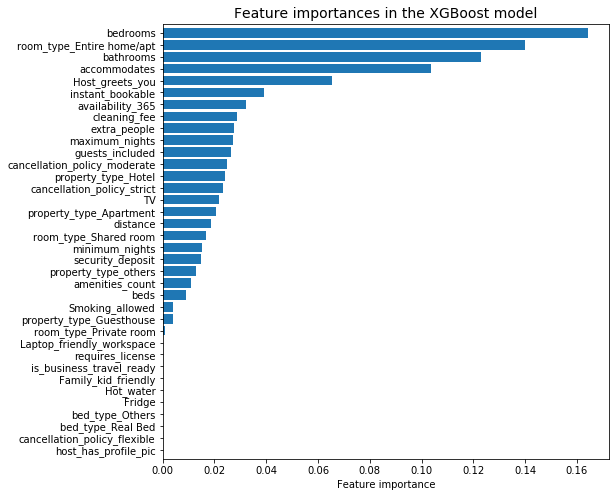

In [95]:
import xgboost as xgb

# Fitting the model
xgb_reg = xgb.XGBRegressor(silent=True)
xgb_reg.fit(X_train, y_train)
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)

# Printing the results
print("\nTraining RMSE:", round(mean_squared_error(y_train, training_preds_xgb_reg, squared=False),2))
print("Validation RMSE:", round(mean_squared_error(y_test, val_preds_xgb_reg, squared=False),2))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),2))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg),2))

# Producing a dataframe of feature importances
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['total_price'], index=columns_in_prediction)
ft_weights_xgb_reg.sort_values('total_price', inplace=True)

# Plotting feature importances
plt.figure(figsize=(8,8))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg['total_price'], align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()